In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# import oskar
# scripts = oskar.Scripts()
import numpy as np
from tqdm import tqdm
import numpy
import matplotlib.pyplot as plot
import sys
import pickle as pkl
# import pyvisa as visa
import visa
import datetime
from scipy.optimize import curve_fit

from collections import defaultdict
from scipy.stats import kurtosis, skew
import pandas as pd
# import xarray as xr
from collections import OrderedDict
from pathlib import Path
import fnmatch
import time

Connect the GPIB - usb cable to electron PC, then run this script together with the artiq zotino_calibrator script

In [18]:
interval_in_ms = 600
count = 1
number_of_pins = 32
volt_set = np.arange(-3,3.1,0.5)
# volt_set = [-2.00000000e-01, -1.80000000e-01, -1.60000000e-01, -1.40000000e-01]
# volt_set = [-1.5,-1.4,-1.3,-1.2,-1.1,-1.,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5]
number_of_datapoints = len(volt_set)
volt_measure = np.zeros((number_of_pins,number_of_datapoints))
volt_set

array([-3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,
        2.5,  3. ])

In [19]:
volt_set = [-3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,
        2.5,  3. ]

# External trigger mode

connect the artiq ttl output to the external trig of the digital multimeter

In [20]:
rm = visa.ResourceManager()
instruments = rm.list_resources()
# instruments
usb = list(filter(lambda x: 'USB' in x, instruments))
if len(usb) != 1:
    print('Bad instrument list', instruments)
    sys.exit(-1)
keithley = rm.open_resource(usb[0])

In [21]:
instruments

(u'USB0::1510::8448::1243106::0::INSTR',)

change artiq Vs manually, run this block then quickly run artiq DAC calibration 

In [63]:
keithley.query('fetch?')

u'-1.17967736E+01'

In [164]:
pin = 25 # artiq zotino channel number, the same as the zotino_channel in zotino calibrator, notice this is not Dsub pin!!

for i in tqdm(range(number_of_datapoints)):
    
    keithley.write("trigger:source external")
    keithley.write("trigger:delay %f" % (interval_in_ms / 1000.0))
    keithley.write("trigger:count %d" % count)
    keithley.write("initiate")
    time.sleep(4)
    
    volt_measure[pin][i] = float(keithley.query('fetch?'))
    keithley.write("*rst; status:preset; *cls")

print(volt_measure[pin])

100%|██████████| 13/13 [00:52<00:00,  4.05s/it]

[-1.17620040e+01 -9.80437184e+00 -7.84298816e+00 -5.87959360e+00
 -5.59741248e+00 -1.95474160e+00  7.31149056e-03  1.96972416e+00
  3.93286080e+00  5.89439680e+00  7.85801088e+00  9.82052608e+00
  1.17818328e+01]


In [71]:
volt_measure

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [-11.74948   ,  -9.78986048,  -7.82880704,  -5.8665824 ,
         -3.90021664,  -1.93923952,   0.01836819,   1.9796832 ,
          3.69202304,   5.9031488 ,   7.86593472,   9.82688512,
         11.7881592 ],
       [-11.7942864 ,  -9.832496  ,  -7.87601536,  -5.91400832,
         -3.95294528,  -1.99065552,  -0.02959645,   1.93190528,
          3.89092384,   5.85131136,   7.81739328,   9.77831872,
         11.7326168 ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [-11.7964952 ,  -9.83742016,  -7.8748928 ,  -5.91409024,
         -3.9529664 ,  -1.9905952 ,  -0.03281702,   1.93186288,
          3.

3.9244184386813195
0.008596723889230592


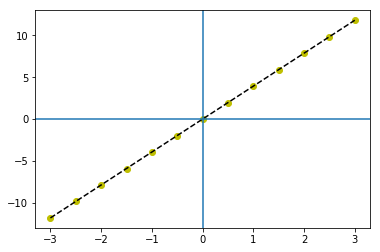

In [167]:
i = pin
m,b = np.polyfit(volt_set, volt_measure[i], 1)
print(m)
print(b)
plt.plot(volt_set, volt_measure[i], 'yo', volt_set, [m*v+b for v in volt_set], '--k',label=i)
#         plt.legend()

# plt.xlim(-0.01,0.01)
# plt.ylim(-0.01,0.01)
plt.axvline(0)
plt.axhline(0)

## Only run this if has individual error, and first run artiq calibration script w/o voltage scan

In [166]:
# pin = 4
voltage_set = -1
index = volt_set.index(voltage_set)
volt = float(keithley.query('MEAS:VOLT:DC?'))
print(volt)
measured_V = volt
volt_measure[pin][index] = measured_V

-3.9092064


In [30]:
volt_measure

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [-11.74948   ,  -9.78986048,  -7.82880704,  -5.8665824 ,
         -3.90021664,  -3.75595808,   0.01836819,   1.9796832 ,
          3.69202304,   5.9031488 ,   7.86593472,   9.82688512,
         11.7881592 ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.

## Data processing

In [168]:
slope = np.ones(number_of_pins)
y0 = np.zeros(number_of_pins)
calibrated_pins = [1, 2, 10, 4, 6, 11, 8, 12, 9, 13, 7, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

In [169]:
slope

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

array([[ 0.00000000e+00,  1.24504615e-06, -2.98103114e-02,
         0.00000000e+00, -3.00626137e-02,  0.00000000e+00,
        -3.04520128e-02,  1.71596016e-03,  1.84998959e-02,
        -3.67513927e-02,  2.43142479e-02,  2.13346698e-02,
         4.02107966e-03,  1.30422121e-02,  0.00000000e+00,
         1.34162940e-02,  0.00000000e+00, -2.99056574e-02,
         4.64065174e-02,  2.14652671e-02,  3.97991825e-02,
         1.60274270e-02,  3.89955695e-02, -3.19373253e-02,
        -3.23027591e-02,  8.59672389e-03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  3.91759479e+00,  3.92192731e+00,
         1.00000000e+00,  3.92262443e+00,  1.00000000e+00,
         3.92252437e+00,  3.92196519e+00,  3.92332923e+00,
         3.92395646e+00,  3.92375149e+00,  3.92489908e+00,
         3.92387325e+00,  3.92332266e+00,  1.00000000e+00,
         3.92382521e+00,  0.00000000e+00,  3.92312920e+00,
         3.92

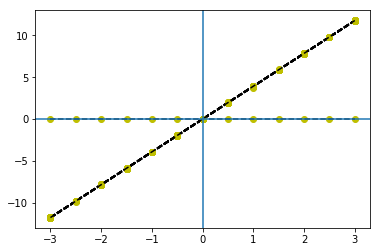

In [171]:
# slope = []
# y0 = []
for i,pin in enumerate(calibrated_pins):
    m,b = np.polyfit(volt_set, volt_measure[pin], 1)
    slope[pin] = m
    y0[pin] = b
    plt.plot(volt_set, volt_measure[pin], 'yo', volt_set, [m*v+b for v in volt_set], '--k',label=pin)
#         plt.legend()

# plt.xlim(-0.01,0.01)
# plt.ylim(-0.01,0.01)
plt.axvline(0)
plt.axhline(0)

fits = np.array([y0,slope])
np.savetxt('zotino_calibration_3layer_smaller_spacer_with_amp.txt',fits)
fits

# Test reading file

In [99]:
f = 'zotino_measure_NEWAMPLIFIER_newground_fits.txt'
tmp = np.loadtxt(f)
tmp
tmp[0][0]
# offset = np.zeros((tmp.shape[0],tmp.shape[1]+1))
# for i in range(tmp.shape[0]):
#     a = np.append(tmp[i],tmp[i][-1])
#     offset[i] = a
# self.dac_calibration_fit = offset

-0.00449822624

In [105]:
f = open('Cfile_3layer.txt','r')
# create list of lines from selected textfile
list_of_lists = []
for line in f:
    stripped_line = line.strip()
    line_list = stripped_line.split()
    list_of_lists.append(float(line_list[0]))
#     print(line_list)